In [1]:
import warnings
from importlib import reload
from functools import partial, lru_cache
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm, trange
from joblib import delayed
from modAL import batch
from art.metrics import empirical_robustness
from art.attacks.evasion import *
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from tabulate import tabulate
from art.estimators.classification.scikitlearn import ScikitlearnSVC
from sklearn.metrics.pairwise import paired_distances, euclidean_distances
import scipy

from ipynb.fs.defs import Bias
from ipynb.fs.defs.Datasets import generateData_twoPills_2D, generateData_twoPills_noNoise_2D, plot_dataset_2D

import libactive
import libadversarial
from libactive import MyActiveLearner, active_split
from libadversarial import adversarial, uncertainty, random_batch, uncertainty_stop
from libutil import ProgressParallel
from libdatasets import *
import librun
from librun import run

Using sklearn


In [2]:
def diffs(classifiers, metric=metrics.accuracy_score, nth='previous'):
    x = []
    diffs = []
    for clf, last in zip(classifiers, [None, *classifiers[:-1]]):
        if last is None:
            continue
        if nth is int:
            last = classifiers[nth]
        x.append(clf.X_training.shape[0])
        
        if metric == roc_auc_score:
            if len(np.unique(clf.y_training)) > 2 or len(clf.y_training.shape) > 1:
                diffs.append(metric(clf.y_training, clf.predict_proba(clf.X_training), multi_class="ovr")-metric(clf.y_training, last.predict_proba(clf.X_training), multi_class="ovr"))
            else:
                diffs.append(metric(clf.y_training, clf.predict_proba(clf.X_training)[:,1])-metric(clf.y_training, last.predict_proba(clf.X_training)[:,1]))
        else:
            diffs.append(metric(clf.y_training, clf.predict(clf.X_training))-metric(clf.y_training, last.predict(clf.X_training)))
    return x, diffs

def grads(classifiers, metric=metrics.accuracy_score, nth='previous'):
    x, _diffs = diffs(classifiers, metric, nth)
    return x, np.gradient(_diffs)

def acc(classifiers, metric=metrics.accuracy_score, nth=0):
    x = []
    diffs = []
    if isinstance(nth, int):
        start = nth+1 
    elif nth == 'last':
        start = 1
    else:
        start = 0
    for i, clf in enumerate(classifiers[start:]):
        #if nth is int and i < nth:
        #    x.append(clf.X_training.shape[0])
        #    diffs.append(np.inf)
        x.append(clf.X_training.shape[0])
        
        if clf.y_training.shape[0] <= 10:
            diffs.append(np.inf)
            continue
        size = 10
        if isinstance(nth, int):
            pclf = classifiers[nth]
        elif nth == 'last':
            pclf = classifiers[i-1]
        else:
            pclf = classifiers[0]
            
        if metric == roc_auc_score:
            if len(np.unique(clf.y_training)) > 2 or len(clf.y_training.shape) > 1:
                diffs.append(metric(clf.y_training[:-size], pclf.predict_proba(clf.X_training[:-size]), multi_class="ovr"))
            else:
                diffs.append(metric(clf.y_training[:-size], pclf.predict_proba(clf.X_training[:-size])[:,1]))
        else:
            diffs.append(metric(clf.y_training[:-size], pclf.predict(clf.X_training[:-size])))
    return x, diffs
    
def stop_criterion2(classifiers, threshold=1e-2, n=10, metric=metrics.accuracy_score):
    x, _diffs = diffs(classifiers, metric)
    _grads = np.gradient(_diffs)
    for i in range(10, len(_diffs)):
        if (np.abs(_diffs[i-n:i]) < threshold).all():
            return x[i], x, _grads
    return np.inf, x, _grads

def stop_criterion3(classifiers, threshold=1e-2, n=10, metric=metrics.accuracy_score):    
    x, _diffs = diffs(classifiers, metric)
    _grads = np.gradient(_diffs)
    for i in range(10, len(_diffs)):
        if (np.abs(_diffs[i-n:i]) < threshold).all():
            return x[i], x, _grads
    return np.inf, x, _grads

def no_ahead_grad(x):
    """
    Compute a gradient across x, ensuring that no values ahead of the current are used for the
    gradient calculation.
    """
    return [np.inf,np.inf, *[np.gradient(x[:i])[-1] for i in range(2, len(x))]]

def stop_criterion4(classifiers, eps=0, n=3, metric=metrics.accuracy_score, nth='first'):
    """
    Last n grad acc (first) were positive.
    """
    x, accs = acc(classifiers, nth=nth)
    #grad_accs = np.gradient(accs)
    grad_accs = no_ahead_grad(accs)
    for i in range(n, len(grad_accs)):
        if all(grad_accs[i-x]>eps for x in range(n)):
            return x[i], x

In [89]:
matrix = {
    # Dataset fetchers should cache if possible
    # Lambda wrapper required for function to be pickleable (sent to other threads via joblib)
    "datasets": [
        ("bbbp", lambda: lru_cache()(bbbp)()),
        ("car", lambda: lru_cache()(car)()),
        ("mnist", lambda: lru_cache()(mnist)()),
        ("german", lambda: lru_cache()(german)()),
    ],
    "dataset_mutators": {
        "none": (lambda *x: x),
    },
    "methods": [
        ("uncertainty", partial(uncertainty_stop, n_instances=10)),
    ],
    "models": [
        "svm-linear"
    ],
    "meta": {
        "dataset_size": 1000,
        "labelled_size": 0.01,
        "n_runs": 1,
        "ret_classifiers": True,
        "ensure_y": True,
        "stop_info": True
    }
}

In [90]:
capture_metrics = [
    accuracy_score,
    f1_score,
    roc_auc_score,
    "uncertainty_average",
    "uncertainty_min",
    "n_support",
]

In [91]:
results4 = librun.run(matrix, metrics=capture_metrics, force_cache=True)
results4_plots = [result[0] for result in results4]
classifiers4 = [result[1] for result in results4]
classifiers4 = [clf[0] for clf in classifiers4]

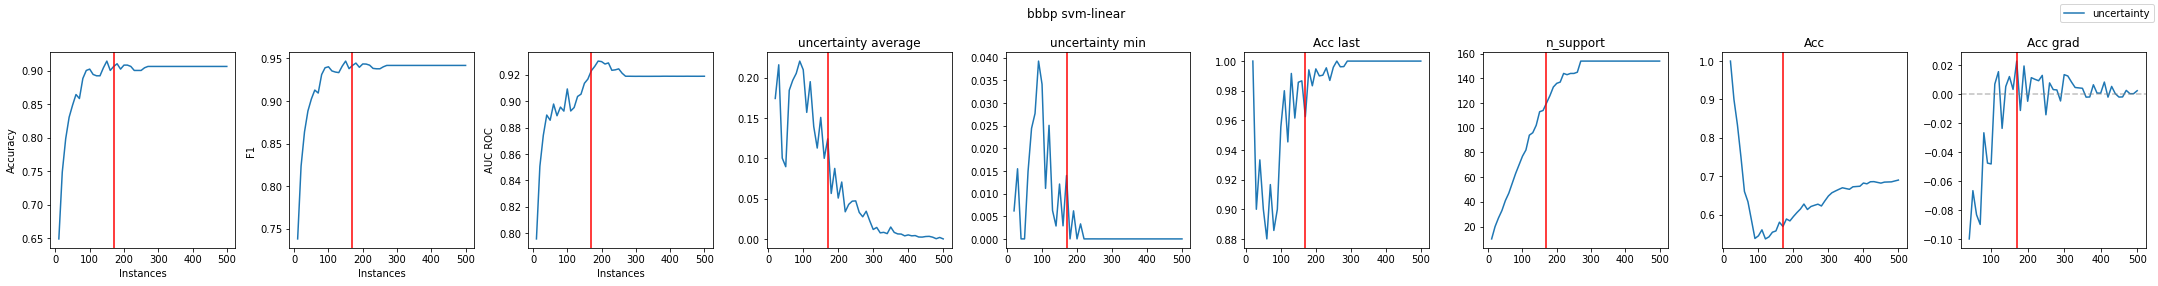

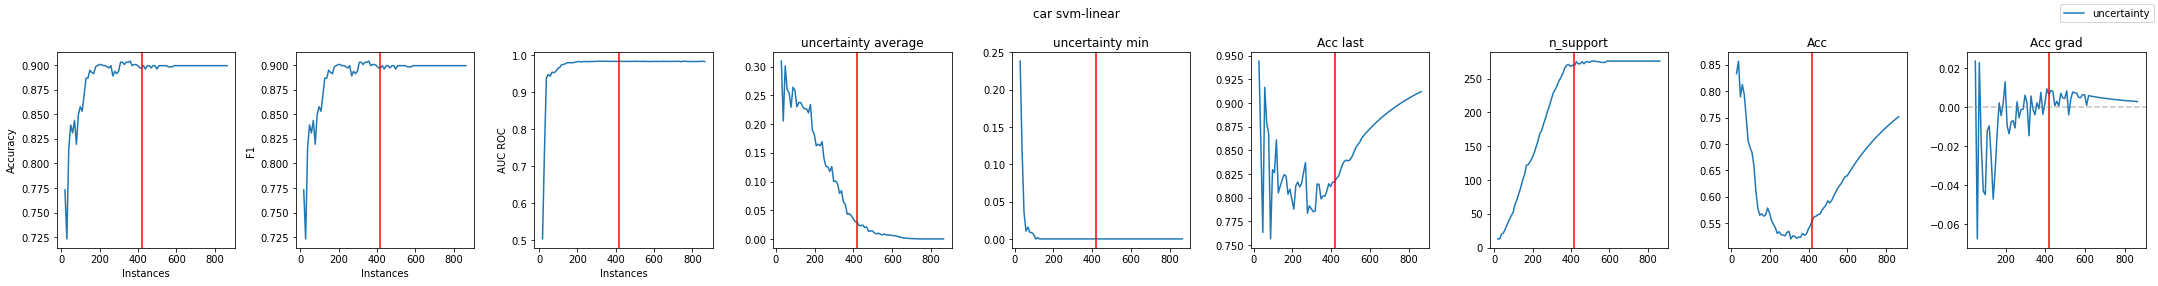

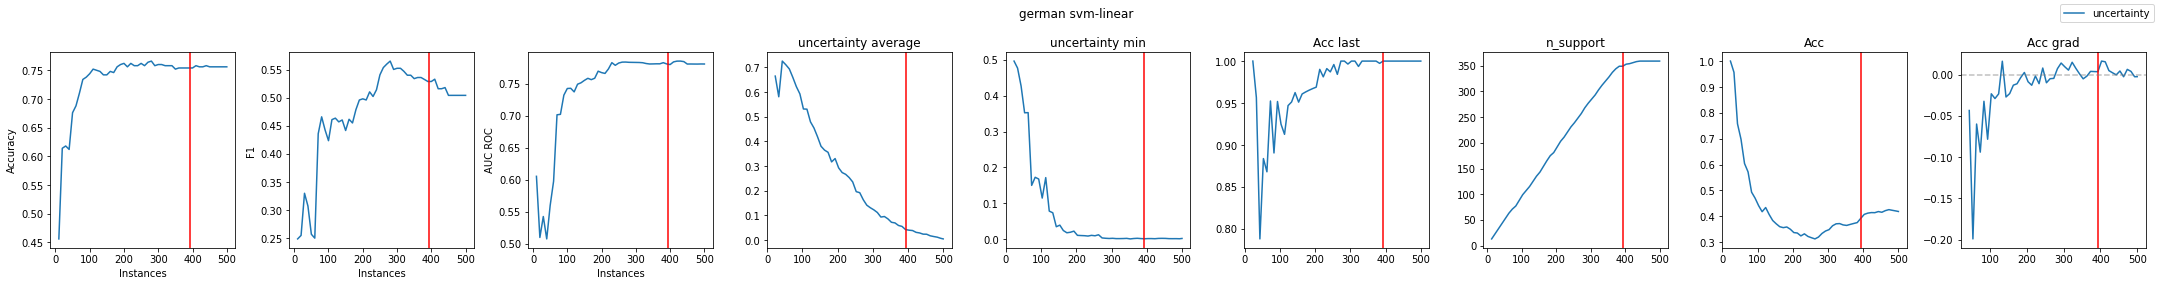

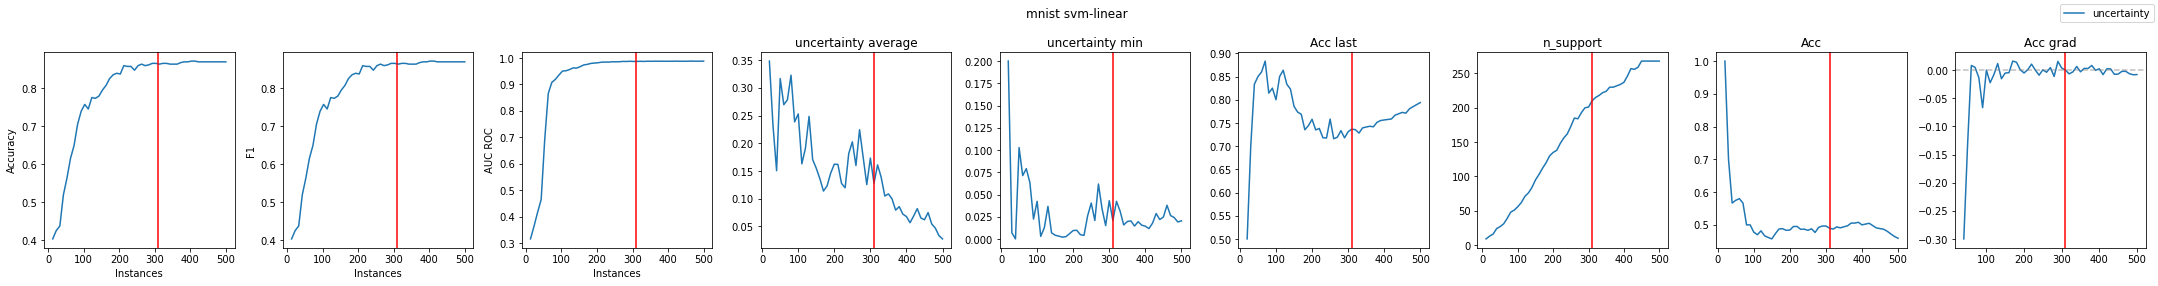

In [7]:
figaxes = librun.plot(results4_plots, ret=True, extra=6, figsize=(30,4))
for i, (fig, ax) in enumerate(figaxes):
    stop, x, = stop_criterion4(classifiers4[i], nth=2)#metric=metrics.roc_auc_score)
    gradsx, _grads = grads(classifiers4[i])
    dx, _diffs = diffs(classifiers4[i])
    accx, _acc = acc(classifiers4[i], nth=0, )#metric=metrics.roc_auc_score)
    ax[-6].set_title("uncertainty average")
    ax[-6].plot(results4_plots[i][1]['x'], results4_plots[i][1]['uncertainty_average'])
    ax[-5].set_title("uncertainty min")
    ax[-5].plot(results4_plots[i][1]['x'], results4_plots[i][1]['uncertainty_min'])
    
    ax[-4].set_title("Acc last")
    ax[-4].plot(*acc(classifiers4[i], nth='last', ))
    
    ax[-3].set_title("n_support")
    ax[-3].plot(results4_plots[i][1]['x'], results4_plots[i][1]['n_support'])
    
    #ax[-3].set_title("expected error")
    #ax[-3].plot(results4_plots[i][1]['x'], results4_plots[i][1]['expected_error'])
    
    ax[-2].set_title("Acc")
    ax[-2].plot(accx, _acc)
    ax[-1].set_title("Acc grad")
    ax[-1].plot(accx, no_ahead_grad(_acc))
    #ax[-1].plot(x, interp1d(x, np.abs(grads), kind='cubic')(x))
    for a in ax:
        a.axvline(stop, c='red')
    ax[-1].axhline(0, ls='--', c='grey', alpha=0.5)
    fig.tight_layout()

## TVREGDIFF

In [8]:
from tvregdiff.tvregdiff import TVRegDiff

In [33]:
def no_ahead_tvregdiff(value, *args, **kwargs):
    out = [np.nan, np.nan]
    for i in range(2, len(value)):
        out.append(TVRegDiff(value[:i], *args, **kwargs)[-1])
    return out

In [47]:
def stop_criterion5(classifiers):
    accx, _acc = acc(classifiers, nth=0)
    grad = np.array(no_ahead_tvregdiff(_acc, 1, 1e-2, plotflag=False, diagflag=False))
    start = np.argmax(grad < 0)
    return accx[np.argmax(grad[start:] >= 0)+start]

In [43]:
accx, _acc = acc(classifiers4[1], nth=0)
grad = np.array(no_ahead_tvregdiff(_acc, 1, 0.2, plotflag=False, diagflag=False))
grad

array([        nan,         nan,  0.04761905, -0.03959363, -0.03765151,
       -0.04924783, -0.08579458, -0.13208963, -0.16552974, -0.18499123,
       -0.20870575, -0.25131273, -0.29606703, -0.32653929, -0.33198127,
       -0.32628851, -0.30902583, -0.27459502, -0.24395347, -0.22682463,
       -0.21369484, -0.20455106, -0.20124266, -0.19030049, -0.18103883,
       -0.17030224, -0.15936478, -0.14181771, -0.12330109, -0.1159394 ,
       -0.10031518, -0.07853319, -0.06498223, -0.04921659, -0.01800385,
       -0.05567437, -0.04403925, -0.03172919, -0.00993905,  0.01982818,
        0.04306072,  0.07823037,  0.09734095,  0.13041083,  0.15153895,
        0.16293753,  0.18169421,  0.18270628,  0.20669645,  0.20455921,
        0.22291967,  0.19287678,  0.24791507,  0.24658609,  0.26338352,
        0.31661774,  0.29539534,  0.31915736,  0.3190298 ,  0.33976423,
        0.31746111,  0.31537433,  0.37168829,  0.3811937 ,  0.43912884,
        0.44394064,  0.56546929,  0.48701417,  0.42164523,  0.44

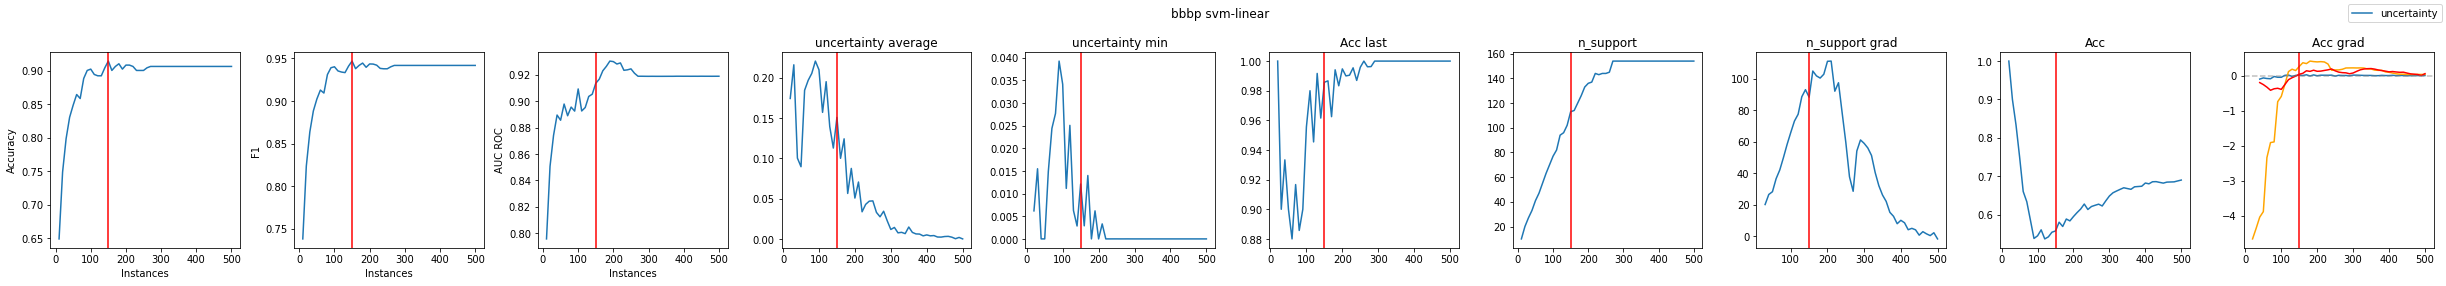

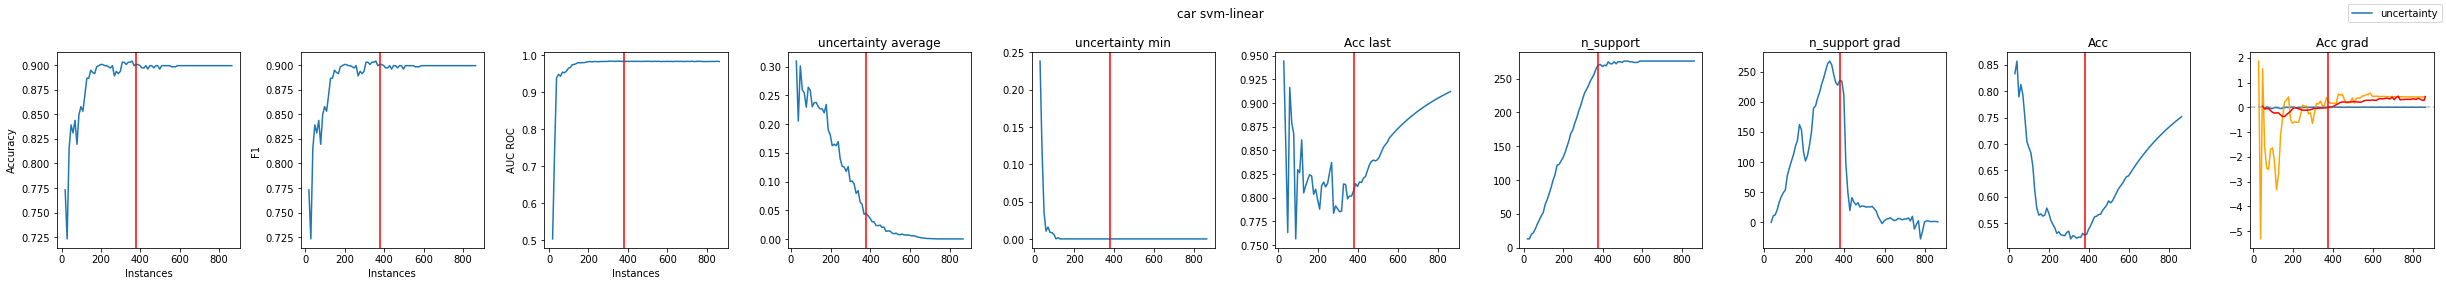

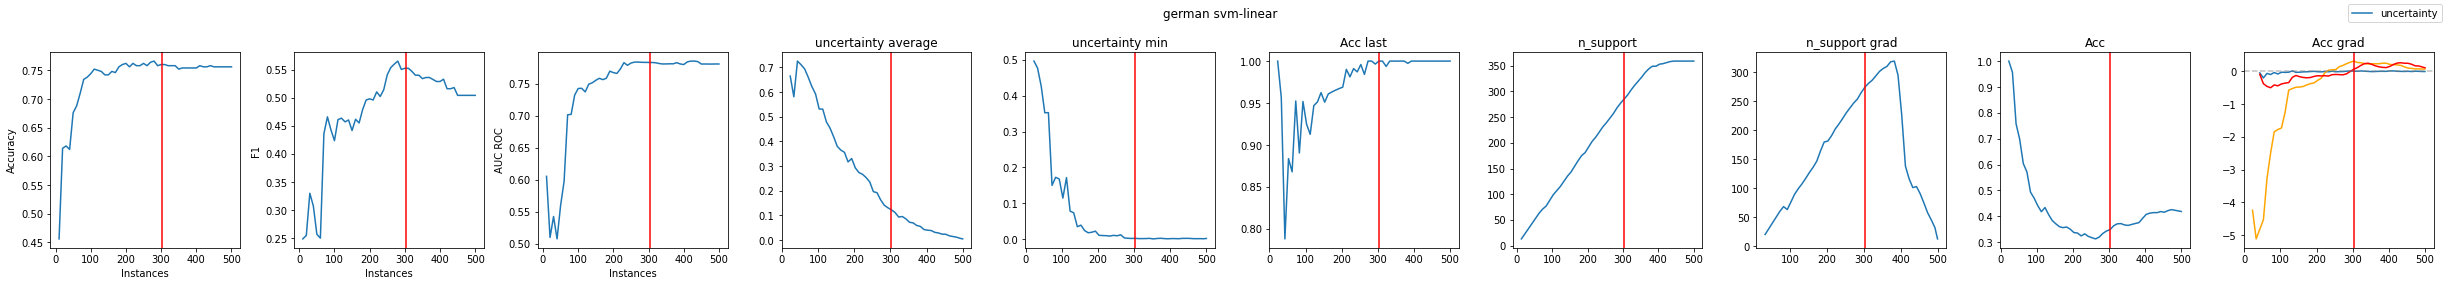

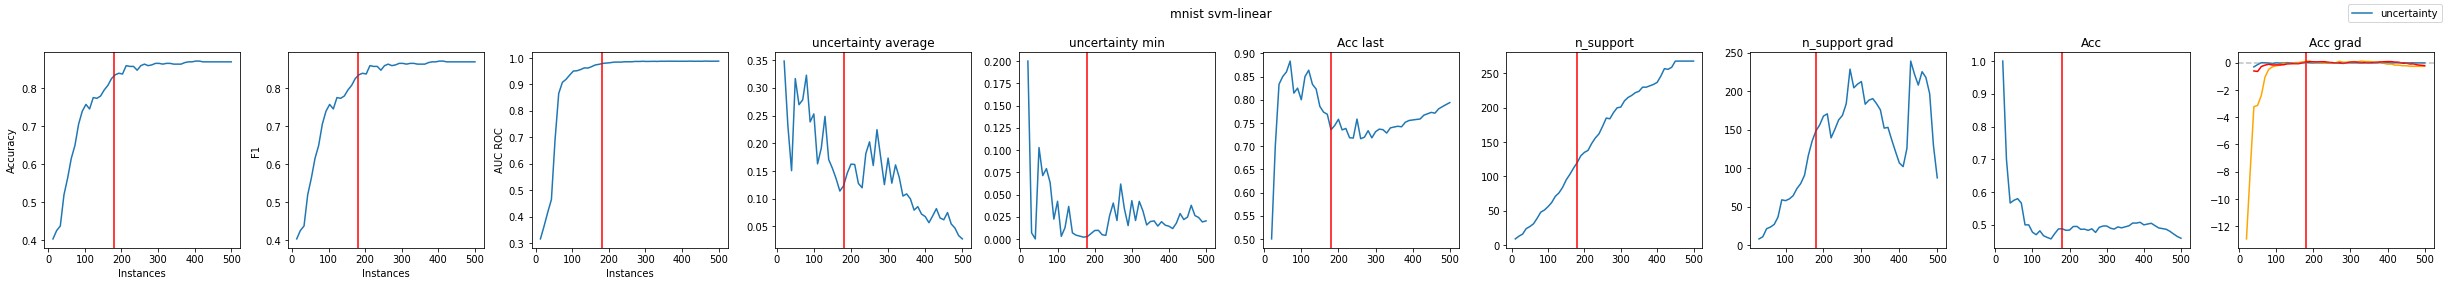

In [94]:
figaxes = librun.plot(results4_plots, ret=True, extra=7, figsize=(34,4))
for i, (fig, ax) in enumerate(figaxes):
    #stop, x, = stop_criterion4(classifiers4[i], nth=2)#metric=metrics.roc_auc_score)
    stop = stop_criterion5(classifiers4[i])
    #break
    gradsx, _grads = grads(classifiers4[i])
    dx, _diffs = diffs(classifiers4[i])
    accx, _acc = acc(classifiers4[i], nth=0, )#metric=metrics.roc_auc_score)
    ax[-7].set_title("uncertainty average")
    ax[-7].plot(results4_plots[i][1]['x'], results4_plots[i][1]['uncertainty_average'])
    ax[-6].set_title("uncertainty min")
    ax[-6].plot(results4_plots[i][1]['x'], results4_plots[i][1]['uncertainty_min'])
    
    ax[-5].set_title("Acc last")
    ax[-5].plot(*acc(classifiers4[i], nth='last', ))
    
    ax[-4].set_title("n_support")
    ax[-4].plot(results4_plots[i][1]['x'], results4_plots[i][1]['n_support'])
    
    ax[-3].set_title("n_support grad")
    ax[-3].plot(results4_plots[i][1]['x'], no_ahead_tvregdiff(results4_plots[i][1]['n_support'], 10, 0.2, plotflag=False, diagflag=False))
    
    #ax[-3].set_title("expected error")
    #ax[-3].plot(results4_plots[i][1]['x'], results4_plots[i][1]['expected_error'])
    
    ax[-2].set_title("Acc")
    ax[-2].plot(accx, _acc)
    ax[-1].set_title("Acc grad")
    ax[-1].plot(accx, no_ahead_grad(_acc))
    
    # WARNING - convergence to tolerance not achieved!
    # Might need to adjust parameters
    ax[-1].plot(accx, TVRegDiff(_acc, 1, 1e-2, plotflag=False, diagflag=False), color='orange')
    ax[-1].plot(accx, no_ahead_tvregdiff(_acc, 1, 1e-2, plotflag=False, diagflag=False), color='red')
    
    #ax[-1].plot(x, interp1d(x, np.abs(grads), kind='cubic')(x))
    for a in ax:
        a.axvline(stop, c='red')
    ax[-1].axhline(0, ls='--', c='grey', alpha=0.5)
    fig.tight_layout()

## Is our artifical saturation problematic?

In [58]:
import libdatasets; reload(libdatasets); from libdatasets import mnist

In [84]:
matrix = {
    # Dataset fetchers should cache if possible
    # Lambda wrapper required for function to be pickleable (sent to other threads via joblib)
    "datasets": [
        ("mnist", lambda: lru_cache()(mnist)(dataset_size=10000)),
    ],
    "dataset_mutators": {
        "none": (lambda *x: x),
    },
    "methods": [
        ("uncertainty", partial(uncertainty_stop, n_instances=10)),
    ],
    "models": [
        "svm-linear"
    ],
    "meta": {
        "dataset_size": 10000,
        "labelled_size": 0.00025,
        "test_size": 0.2,
        "n_runs": 1,
        "ret_classifiers": True,
        "ensure_y": True,
        "stop_info": True,
        "stop_function": ("len1000", lambda learner: learner.y_training.shape[0] >= 1000)
    }
}

In [68]:
capture_metrics = [
    accuracy_score,
    f1_score,
    roc_auc_score,
    "uncertainty_average",
    "uncertainty_min",
    "n_support",
]

In [85]:
results4 = librun.run(matrix, metrics=capture_metrics, force_run=True)
results4_plots = [result[0] for result in results4]
classifiers4 = [result[1] for result in results4]
classifiers4 = [clf[0] for clf in classifiers4]

In [74]:
X, y = mnist(dataset_size=10000)

In [83]:
X_labelled, X_unlabelled, Y_labelled, Y_oracle, X_test, Y_test = active_split(X, y, labeled_size=0.00025, test_size=0.2)
print(f"labelled {len(Y_labelled)} oracle {len(Y_oracle)} test {len(Y_test)}")

labelled 13 oracle 7987 test 2000


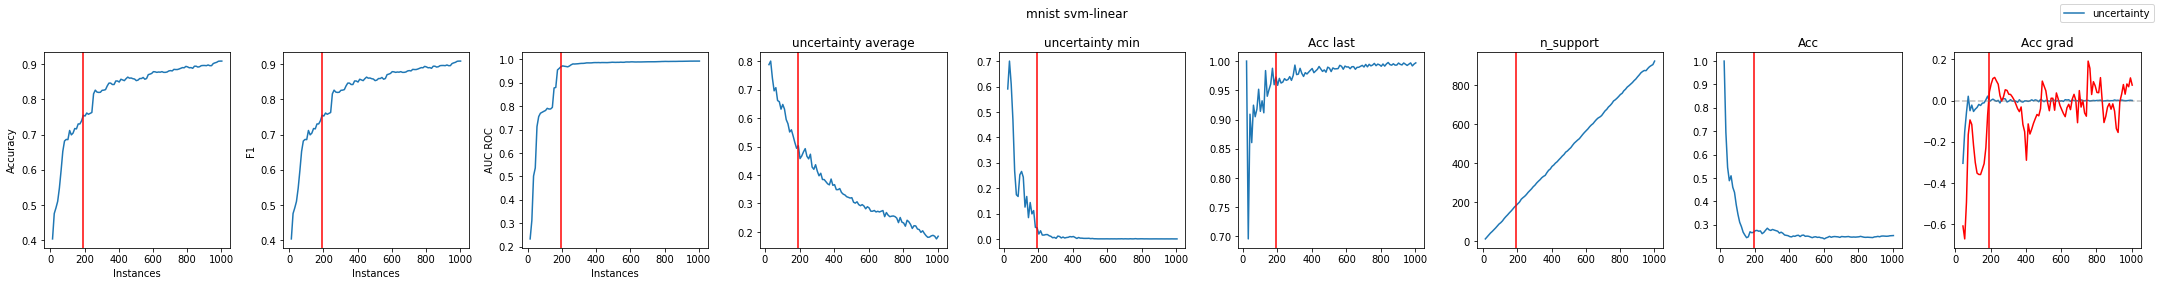

In [87]:
figaxes = librun.plot(results4_plots, ret=True, extra=6, figsize=(30,4))
for i, (fig, ax) in enumerate(figaxes):
    #stop, x, = stop_criterion4(classifiers4[i], nth=2)#metric=metrics.roc_auc_score)
    stop = stop_criterion5(classifiers4[i])
    #break
    gradsx, _grads = grads(classifiers4[i])
    dx, _diffs = diffs(classifiers4[i])
    accx, _acc = acc(classifiers4[i], nth=0, )#metric=metrics.roc_auc_score)
    ax[-6].set_title("uncertainty average")
    ax[-6].plot(results4_plots[i][1]['x'], results4_plots[i][1]['uncertainty_average'])
    ax[-5].set_title("uncertainty min")
    ax[-5].plot(results4_plots[i][1]['x'], results4_plots[i][1]['uncertainty_min'])
    
    ax[-4].set_title("Acc last")
    ax[-4].plot(*acc(classifiers4[i], nth='last', ))
    
    ax[-3].set_title("n_support")
    ax[-3].plot(results4_plots[i][1]['x'], results4_plots[i][1]['n_support'])
    
    #ax[-3].set_title("expected error")
    #ax[-3].plot(results4_plots[i][1]['x'], results4_plots[i][1]['expected_error'])
    
    ax[-2].set_title("Acc")
    ax[-2].plot(accx, _acc)
    ax[-1].set_title("Acc grad")
    ax[-1].plot(accx, no_ahead_grad(_acc))
    
    # WARNING - convergence to tolerance not achieved!
    # Might need to adjust parameters
    #ax[-1].plot(accx, TVRegDiff(_acc, 1, 1e-2, plotflag=False, diagflag=False), color='orange')
    ax[-1].plot(accx, no_ahead_tvregdiff(_acc, 1, 1e-2, plotflag=False, diagflag=False), color='red')
    
    #ax[-1].plot(x, interp1d(x, np.abs(grads), kind='cubic')(x))
    for a in ax:
        a.axvline(stop, c='red')
    ax[-1].axhline(0, ls='--', c='grey', alpha=0.5)
    fig.tight_layout()